In [1]:
#workhorses
import numpy as np
import pandas as pd

#for custom colormaps
from matplotlib.colors import LinearSegmentedColormap

#for proxy artists for legends
import matplotlib.lines as mlines

import itertools

In [2]:
#plotting things

#%matplotlib qt5 -- I don't know what this is
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from cycler import cycler


#All of Anandh's customized seaborn/matplotlib settings

sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')

    #If you want to use a different font
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 
#                  'serif': ['Helvetica']})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)

## open data

In [3]:
directory = 'Z:/Reed/Projects/micro_consortia/DARPA_biocon/Task 1.1/A=B/20190910 a=b manual dil degorig 1/'

filename = 'cfu counts.xlsx'

df = pd.read_excel(directory + filename)

In [4]:
df.head()

,well,time,c,y,b,dil,e (delete later),ul,conc_c,conc_y,conc_b,notes,frac_c,frac_y,iptg,sal,dhba,dil.1
0,A1,1,NaN,NaN,NaN,100,2.0,10,0.0,0.0,0.000000e+00,uncount,NaN,NaN,0,0,0,0
1,A1,1,NaN,NaN,NaN,1000,3.0,10,0.0,0.0,0.000000e+00,uncount,NaN,NaN,0,0,0,0
2,A1,1,243.0,141.0,384.0,10000,4.0,10,243000000.0,141000000.0,3.840000e+08,NaN,0.632812,0.367188,0,0,0,0
3,A1,1,97.0,54.0,151.0,100000,5.0,10,970000000.0,540000000.0,1.510000e+09,NaN,0.642384,0.357616,0,0,0,0
4,A2,1,NaN,NaN,0.0,100,2.0,10,0.0,0.0,0.000000e+00,uncount,NaN,NaN,0,0,0,0


## plot

In [12]:
# get indices to throw out zero counts if needed

tot_zero = df['notes'] == 'empty'

c_zero = df['c'] == 0

y_zero = df['y'] == 0

no_zeros = ~tot_zero & ~c_zero & ~y_zero

# get rid of uncounted ones

not_count = df['c'] == 'x'

# get indices to separate dils

# g1 = df['time'] <= 18

# g2 = df['time'] > 18

In [15]:
###get/create relevant info for color mapping

#enumerate subconditions
inducers = ['iptg', 'sal']
g = [np.unique(df[ind]) for ind in inducers]


conds = list(itertools.product(g[0], g[1]))



#generate numbers for jitter
nums = np.linspace(-0.7, 0.7, len(conds))
jit = {conc : num for conc,num in zip(conds,nums)}

#create a list of values from x-->1 of same length as unique inducer concs
#this gets fed to the cmap to get rgb colors
mapping_list = np.linspace(0.275,1,len(conds))

###get some colors that cover all the inducer conditions

#select your color map
names = {'b' : 'Blues', 'y' : 'YlOrBr', 'black' : 'binary', 'p' : 'Purples'}

cmaps = {k:mpl.cm.get_cmap(v) for (k,v) in names.items()}


#create a list of rgb tuples
clist = {k : [cmap(x) for x in mapping_list] for (k,cmap) in cmaps.items()}


#create the palette dictionary for the facegrid function
pal = {k : {conc:color for conc,color in zip(conds, rgb_tuples)} for (k, rgb_tuples) in clist.items()}

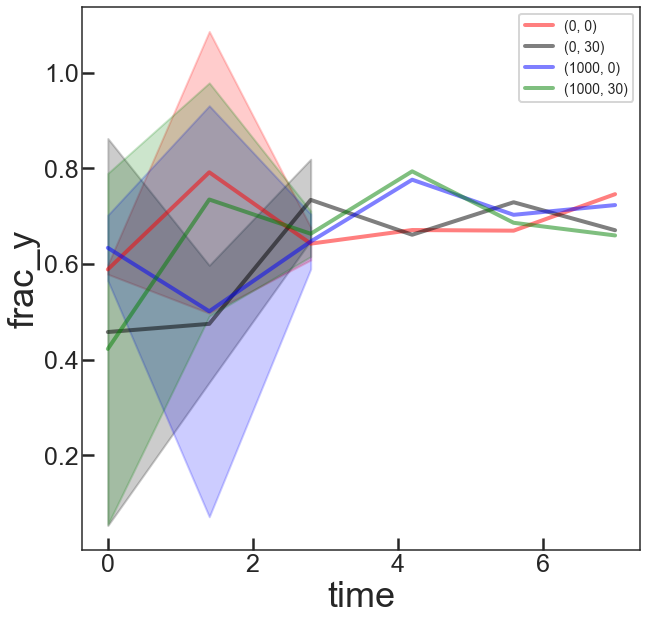

In [24]:
#create plot(s)
fig, ax = plt.subplots(figsize=(10,10))

for cond in conds:

    ii = (df['iptg'] == cond[0]) & (df['sal'] == cond[1])
    
    d = df.loc[ii]
    
    sns.lineplot(x="time", y="frac_y", data=d, ci='sd',
                 lw=4, alpha=0.5,  
                 label=cond, ax=ax)
    
# ax.set_yscale('log')

### total population in a grid

In [445]:
def custom_pal_lineplot (x, y, **kwargs):
    
    #set the plotting to go to the current axis
    #this is a requirement for using function in mapping to facetgrid
    ax = plt.gca()
    
    #set any ax limits you may want
    ax.set_ylim([5*10**4, 10**9])
    
    #remove the data from the kwargs (where facetgrid puts the data)
    #and store it in this variable
    data = kwargs.pop("data")
#     print(data)
    
    #get the passed palette out to get colors for color.
    #facetgrid passes a label in the kwargs too which is whatever value of the "hue"
    #param it is plotting at the moment
    pal = kwargs.pop('palette')
    
    #get the label out
    label = kwargs.pop('label')
#     print(label)
    
#     print(kwargs)

    #create jitter
    data['time'] = data['time'] + kwargs['jitter'][label]
    
    sns.lineplot(x=x, y=y, data=data, ci=kwargs['ci'],
                 err_style='bars',
                 color=pal[label], linewidth=kwargs['linewidth'], marker=kwargs['marker'], markersize=20,
                 ax=ax)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


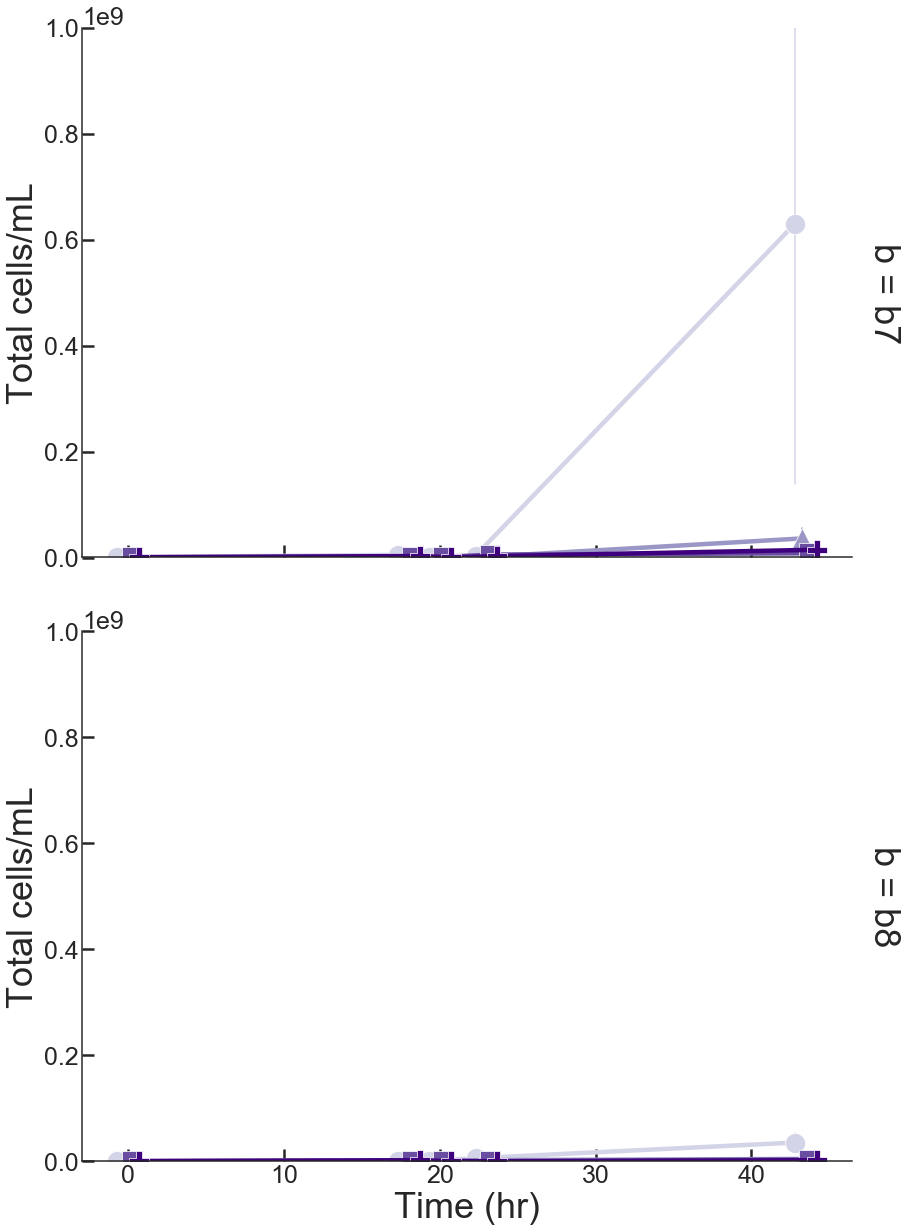

In [446]:
g = sns.FacetGrid(df.drop(columns='notes'), row='b', hue='iptg', hue_kws=dict(marker=['o','^', 's', 'P']),
                  height=9, aspect=1.5, margin_titles=True, legend_out=False)


#set kws for the first set of lines
kws = {'ci': 'sd', 'linewidth' : 4.5, 'palette' : pal['p'], 'jitter' : jit}
g.map_dataframe(custom_pal_lineplot, "time", "conc_b", **kws)

g.set_axis_labels('Time (hr)', "Total cells/mL")



In [447]:
axes = g.fig.get_axes()

In [448]:
for ax in axes:
    ax.set_yscale('log')

In [449]:
#create legend entries
i = np.unique(df['iptg'])
s = np.unique(df['sal'])

ls = ['{}, {}'.format(I,S) for I,S in zip(i,s)]

g.fig.legend(labels = ls, title='IPTG uM, Sal uM',
             fontsize='x-small', bbox_to_anchor=(0.45, 0.93))

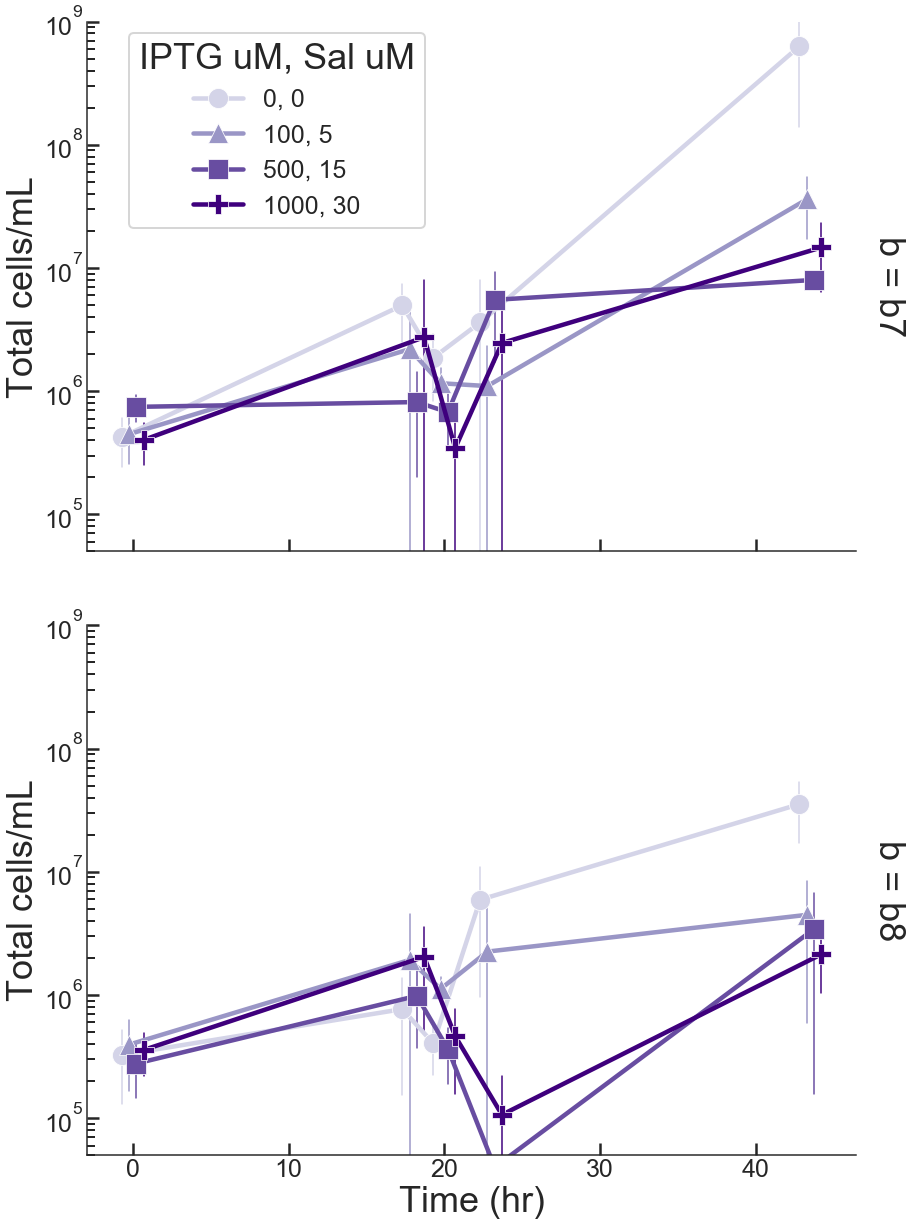

In [450]:
g.fig

In [451]:
# g.savefig(directory + 'cfu_total_conc_log_jit.pdf')

### A cell fraction

In [440]:
def custom_pal_lineplot (x, y, **kwargs):
    
    #set the plotting to go to the current axis
    #this is a requirement for using function in mapping to facetgrid
    ax = plt.gca()
    
    #set any ax limits you may want
    ax.set_ylim([0, 1.1])
    
    #remove the data from the kwargs (where facetgrid puts the data)
    #and store it in this variable
    data = kwargs.pop("data")
#     print(data)
    
    #get the passed palette out to get colors for color.
    #facetgrid passes a label in the kwargs too which is whatever value of the "hue"
    #param it is plotting at the moment
    pal = kwargs.pop('palette')
    
    #get the label out
    label = kwargs.pop('label')
#     print(label)
    
#     print(kwargs)


    #create jitter
    data['time'] = data['time'] + kwargs['jitter'][label]
    
    sns.lineplot(x=x, y=y, data=data, ci=kwargs['ci'],
                 err_style='bars',
                 color=pal[label], linewidth=kwargs['linewidth'], marker=kwargs['marker'], markersize=20,
                 ax=ax)

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


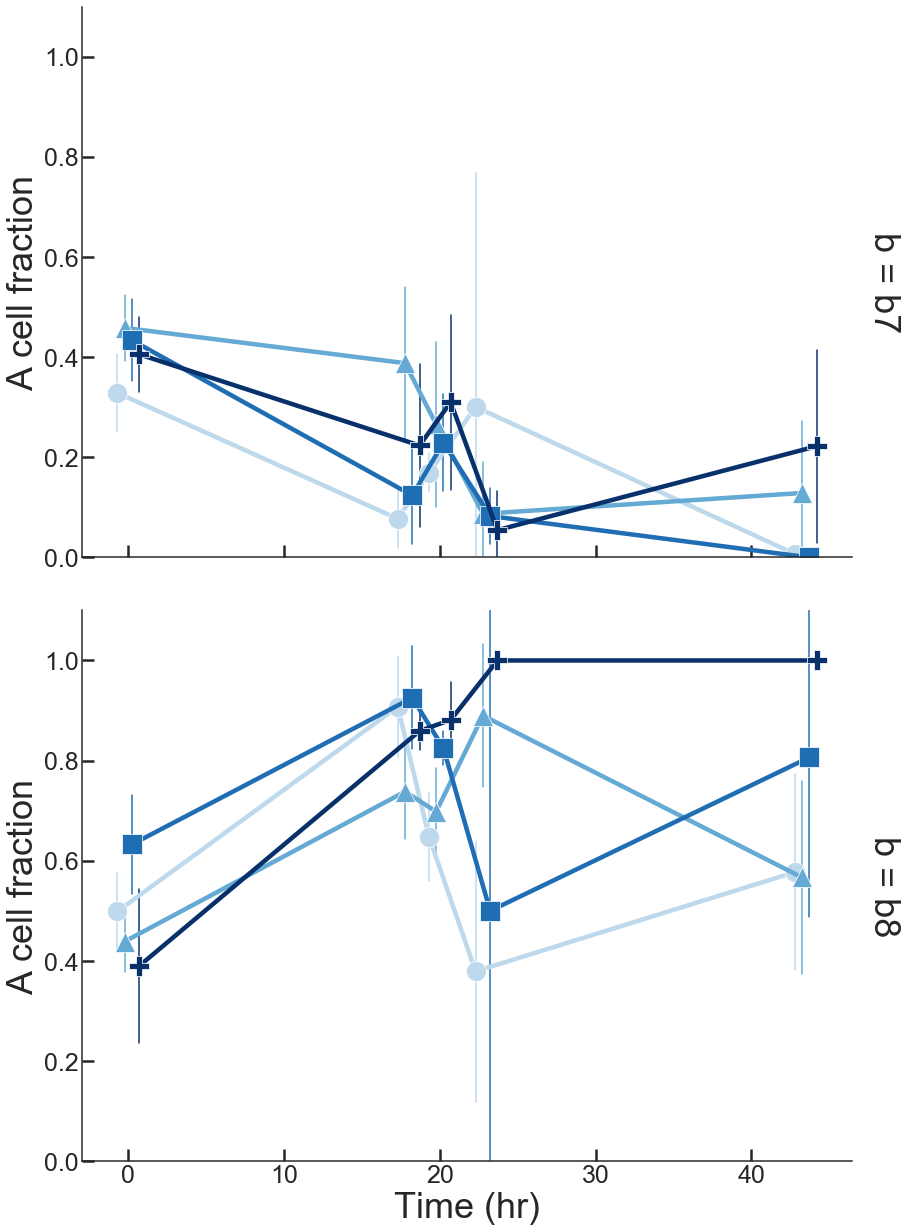

In [441]:
g = sns.FacetGrid(df.drop(columns='notes'), row='b', hue='iptg', hue_kws=dict(marker=['o','^', 's', 'P']),
                  height=9, aspect=1.5, margin_titles=True, legend_out=False)


#set kws for the first set of lines
kws = {'ci': 'sd', 'linewidth' : 4.5, 'palette' : pal['b'], 'jitter' : jit}
g.map_dataframe(custom_pal_lineplot, "time", "frac_c", **kws)

g.set_axis_labels('Time (hr)', "A cell fraction")



In [442]:
#create legend entries
i = np.unique(df['iptg'])
s = np.unique(df['sal'])

ls = ['{}, {}'.format(I,S) for I,S in zip(i,s)]

g.fig.legend(labels = ls, title='IPTG uM, Sal uM',
             fontsize='x-small', bbox_to_anchor=(0.45, 0.93))

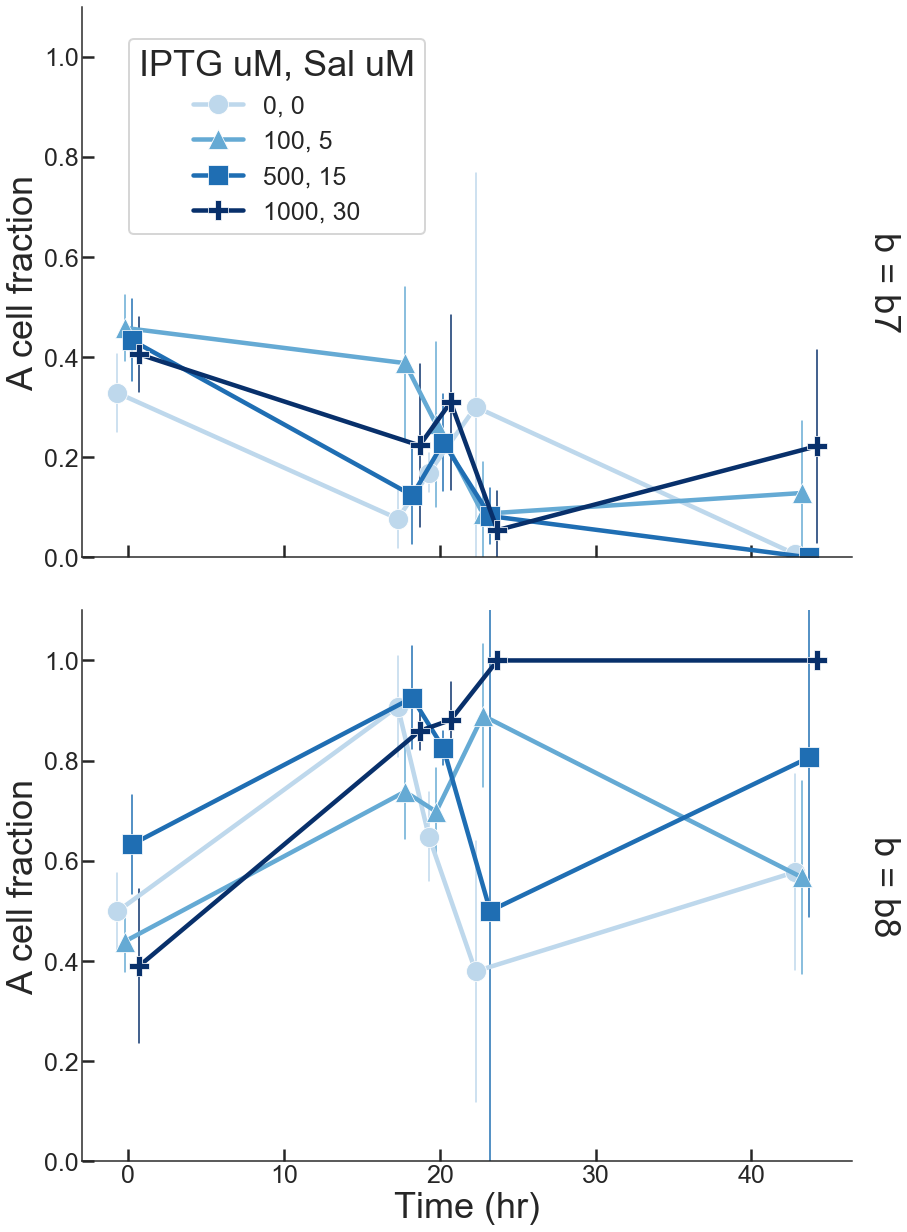

In [443]:
g.fig

In [444]:
g.savefig('cfu_afrac_errbar.pdf')